In [0]:
!pip install lime

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np



from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.applications.inception_v3 import decode_predictions, preprocess_input
from keras.preprocessing.image import  img_to_array



from lime.lime_image import LimeImageExplainer

Using TensorFlow backend.


#**CNN on CIFAR10**

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


[3]


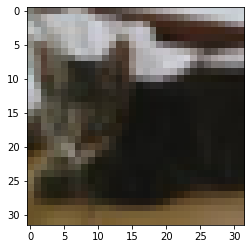

In [0]:
#to have an idea how is composed the dataset
print(y_train[9]) 
plt.imshow(x_train[9], cmap='Greys')

In [0]:
#there are 60.000 obs in the train and 10.000 in the test
print(x_train.shape)
print(x_test.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


In [0]:
#adding the 4th dimension for make shure is possible to use keras
x_train = x_train.reshape(50000, 32, 32, 3)
x_test=x_test.reshape(10000,32,32,3)
#convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

In [0]:
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3)))
  model.add(BatchNormalization()) 
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(2*32, kernel_size=(3,3), input_shape=(28,28,1),padding='same'))
  model.add(BatchNormalization()) 
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  
  model.add(Dense(2*32, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))

  model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  model.fit(x=x_train,y=y_train, epochs=10)


Epoch 1/10
50000/50000 [==============================] - 28s 554us/step - loss: 1.8571 - accuracy: 0.3069
Epoch 2/10
50000/50000 [==============================] - 21s 417us/step - loss: 1.5232 - accuracy: 0.4580
Epoch 3/10
50000/50000 [==============================] - 21s 422us/step - loss: 1.3534 - accuracy: 0.5234
Epoch 4/10
50000/50000 [==============================] - 26s 529us/step - loss: 1.2526 - accuracy: 0.5636
Epoch 5/10
50000/50000 [==============================] - 24s 483us/step - loss: 1.1804 - accuracy: 0.5918
Epoch 6/10
50000/50000 [==============================] - 19s 382us/step - loss: 1.1294 - accuracy: 0.6118
Epoch 7/10
50000/50000 [==============================] - 19s 375us/step - loss: 1.0867 - accuracy: 0.6245
Epoch 8/10
50000/50000 [==============================] - 19s 373us/step - loss: 1.0484 - accuracy: 0.6361
Epoch 9/10
50000/50000 [==============================] - 21s 415us/step - loss: 1.0157 - accuracy: 0.6522
Epoch 10/10
50000/50000 [============

In [0]:
#model = KerasClassifier(build_fn=CNN_model, epochs=10)

In [0]:
#batch_size = [28, 56]
#param_grid = dict(batch_size=batch_size)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,verbose=1)
#grid_result = grid.fit(x_train, y_train)

In [0]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [0]:
model.fit(x_test,y_test)

Epoch 1/1
10000/10000 [==============================] - 3s 263us/step - loss: 1.1241 - accuracy: 0.6244


#**EXPLANATION on CIFAR10**

In [0]:
labels = {
0: 'airplane',
1: 'automobile',
2: 'bird',
3: 'cat',
4: 'deer',
5: 'dog',
6: 'frog',
7: 'horse',
8: 'ship',
9: 'truck'}

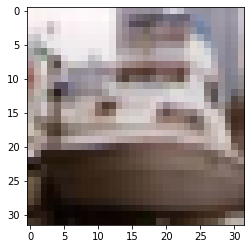

In [0]:
image_test=x_test[random.randrange(len(x_test))]
plt.imshow(image_test.reshape(32,32,3))

In [0]:
image_test = image_test.reshape(1,32,32,3)
prediction = model.predict(image_test)
print(labels[prediction.argmax()])

ship


#lime


In [0]:
from lime.lime_image import LimeImageExplainer

In [0]:
explainer = LimeImageExplainer()

In [0]:
explanation = explainer.explain_instance(image_test[0], #the image
                                         model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=5000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

In [0]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

In [0]:
print(prediction.argsort()[0, -5:][::-1])

[8 1 9 0 2]


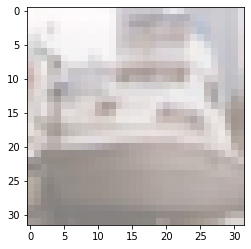

In [0]:
temp, mask = explanation.get_image_and_mask(8, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#saliency maps

In [0]:
import cv2

In [0]:
image_test=image_test.reshape(32,32,3)
image_test=img_to_array(image_test)

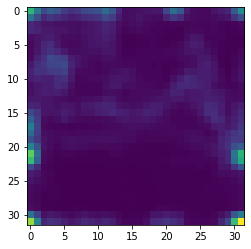

In [0]:
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image_test)
saliencyMap = (saliencyMap*255).astype("uint8")
plt.imshow(image_test)
plt.imshow(saliencyMap)

  Created wheel for pyimagemonkey: filename=pyimagemonkey-0.1-cp36-none-any.whl size=5307 sha256=96b1c786265ded4f4f92dc13971eafe0e6b4a029adec1de9438fb0557515b6f6
  Stored in directory: /root/.cache/pip/wheels/28/b8/93/a468e1b18ebd63ca11b9a5266df0344c7724aaeea746b80df1
Successfully built pyimagemonkey
